In [1]:
# DREADD simulation, with K^, two bottle test
# Simulation for Park et al., 2020 Nature Neurosci.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statistics as st
import random
from scipy import stats
from matplotlib import gridspec
import copy


In [3]:
N_i = 2400# Number of iterations in a set
N_exp = 100# Number of sets of iterations; same as simulation 1

# Parameters ########################

alp_Kh = 0.3# Learning rate (alpha) of K^
alp_Q = 0.03# Learning rate (alpha) of Q
beta = 10# Inverse temperature
tau = [7000, 7000]# Attenuation rate (Water and sodium)

mouth = [0.3, 0.5]# Volume of an intake

H_ast = 50
##################################
fs = 18# Font size
rd = 0.1# Color density of error region

LPBN =  0.3# Constant negative bias
drd = 0.3# DREADD stimulation

In [4]:
y_result = np.zeros((4, 3, 5, N_exp))

In [5]:
class Gen:
    def __init__(self, init_W, init_Na, DREADD):
        self.N = N_i
        self.a = np.zeros(self.N)# 0 ,1 or 2
        self.D = np.zeros(self.N+1)# D(Ht)
        self.D_est = np.zeros(self.N+1)# D(Ht+1)
        self.H = np.zeros((2, self.N+1))# Internal states (water, sodium)
        self.H[0] = init_W
        self.H[1] = init_Na
        self.H_ast = H_ast# The ideal point
        self.P = np.zeros((3,self.N))# P(intake)
        
        self.K = np.zeros((2, self.N))# an intake amount
        self.Kh = np.zeros((2, 3, self.N+1))# K^...oral sense of intake
        self.Q = np.zeros((3, self.N+1))# Action values
        self.Q_drd = np.zeros(3)################
        
        self.LPBN = LPBN
        self.DREADD = DREADD
        
        self.R = np.zeros(self.N)# Reward of each action
        self.m = 3# A constant of the homeostatic space
        self.n = 4# The other constant of the homeostatic space
        
        self.alp_Kh = alp_Kh# Learning rate of K^
        self.alp_Q = alp_Q# Learning rate of Q-value
        self.beta = beta# Inverse temperature
        self.tau = tau
        self.mouth = mouth# Volume of an intake
        
        [self.Q[0][0],self.Q[1][0],self.Q[2][0]] = [0, 0, self.LPBN]
        
        
        
    def softmax(self, t):
        self.t = t
        self.Q_drd = copy.deepcopy(self.Q[:, self.t])
        self.Q_drd[2]=self.Q_drd[2] - LPBN + self.DREADD
        sigma = np.sum(np.exp(self.Q_drd*self.beta))
        vals = []
        for i in range(3):
            softmax = np.exp(self.Q_drd[i]*self.beta)/sigma
            vals.append(softmax)
        
        # 0...Do nothing; 1...Water intake; 2...Saltwater intake
        if i == 0:
            self.P[0][self.t] = softmax
        elif i == 1:
            self.P[1][self.t] = softmax
        elif i == 2:
            self.P[2][self.t] = softmax
            
        dice = random.random()
        if dice <= vals[0]:
            self.a[self.t] = 0
        elif vals[0] < dice <= vals[0]+vals[1]:
            self.a[self.t] = 1
        else:
            self.a[self.t] = 2
        
        
    def get_Kh(self, t):
        self.t = t
        if self.a[self.t] == 0:# Do nothing
            self.K[0][self.t] = 0
            self.K[1][self.t] = 0
            self.Kh[0][0][self.t+1] = self.Kh[0][0][self.t]
            self.Kh[0][1][self.t+1] = self.Kh[0][1][self.t]
            self.Kh[0][2][self.t+1] = self.Kh[0][2][self.t]
            self.Kh[1][0][self.t+1] = self.Kh[1][0][self.t]
            self.Kh[1][1][self.t+1] = self.Kh[1][1][self.t]
            self.Kh[1][2][self.t+1] = self.Kh[1][2][self.t]
        
        elif self.a[self.t] == 1:# Water intake
            self.K[0][self.t] = self.mouth[0]
            self.K[1][self.t] = 0
            self.Kh[0][0][self.t+1] = self.Kh[0][0][self.t]
            self.Kh[0][1][self.t+1] = (1 - self.alp_Kh)*self.Kh[0][1][self.t] + self.alp_Kh*self.mouth[0]
            self.Kh[0][2][self.t+1] = self.Kh[0][2][self.t]
            self.Kh[1][0][self.t+1] = self.Kh[1][0][self.t]
            self.Kh[1][1][self.t+1] = self.Kh[1][1][self.t]
            self.Kh[1][2][self.t+1] = self.Kh[1][2][self.t]
            
        elif self.a[self.t] == 2:# Saltwater intake
            self.K[0][self.t] = self.mouth[0]
            self.K[1][self.t] = self.mouth[1]
            self.Kh[0][0][self.t+1] = self.Kh[0][0][self.t]
            self.Kh[0][1][self.t+1] = self.Kh[0][1][self.t]
            self.Kh[0][2][self.t+1] = (1 - self.alp_Kh)*self.Kh[0][2][self.t] + self.alp_Kh*self.mouth[0]
            self.Kh[1][0][self.t+1] = self.Kh[1][0][self.t]
            self.Kh[1][1][self.t+1] = self.Kh[1][1][self.t]
            self.Kh[1][2][self.t+1] = (1 - self.alp_Kh)*self.Kh[1][2][self.t] + self.alp_Kh*self.mouth[1]
            
        
    def get_D(self, t):
        self.t = t
        self.D[self.t] =  (abs(self.H_ast - self.H[0][self.t])**self.n
                           + abs(self.H_ast - self.H[1][self.t])**self.n)**(1/self.m)
        if self.a[self.t] == 1:
            self.D_est[self.t] = (abs(self.H_ast - (1 - 1/self.tau[0]) * self.H[0][self.t] - self.Kh[0][1][self.t+1])**self.n
                                 + abs(self.H_ast - (1 - 1/self.tau[1]) * self.H[1][self.t] - self.Kh[1][1][self.t+1])**self.n)**(1/self.m)
        elif self.a[self.t] == 2:
            self.D_est[self.t] = (abs(self.H_ast - (1 - 1/self.tau[0]) * self.H[0][self.t] - self.Kh[0][2][self.t+1])**self.n
                                 + abs(self.H_ast - (1 - 1/self.tau[1]) * self.H[1][self.t] - self.Kh[1][2][self.t+1])**self.n)**(1/self.m)
        else:
            self.D_est[self.t] = (abs(self.H_ast - (1 - 1/self.tau[0]) * self.H[0][self.t] - self.Kh[0][0][self.t+1])**self.n
                                 + abs(self.H_ast - (1 - 1/self.tau[1]) * self.H[1][self.t] - self.Kh[1][0][self.t+1])**self.n)**(1/self.m)
        

    def get_R(self, t):
        self.t = t
        self.R[self.t] = self.D[self.t] - self.D_est[self.t]
        
    
    def get_H(self, t):
        self.t = t
        self.H[0][self.t+1] = (1 - 1/self.tau[0]) * self.H[0][self.t] + self.K[0][self.t]
        self.H[1][self.t+1] = (1 - 1/self.tau[1]) * self.H[1][self.t] + self.K[1][self.t]
        
        
    def get_Q(self, t):
        self.t = t
        if self.a[self.t] == 0:
            self.Q[0][self.t+1] = self.Q[0][self.t] + self.alp_Q*(self.R[self.t] - self.Q[0][self.t])
            self.Q[1][self.t+1] = self.Q[1][self.t]
            self.Q[2][self.t+1] = self.Q[2][self.t]
        
        elif self.a[self.t] == 1:
            self.Q[0][self.t+1] = self.Q[0][self.t]
            self.Q[1][self.t+1] = self.Q[1][self.t] + self.alp_Q*(self.R[self.t] - self.Q[1][self.t])
            self.Q[2][self.t+1] = self.Q[2][self.t]
            
        elif self.a[self.t] == 2:
            self.Q[0][self.t+1] = self.Q[0][self.t]
            self.Q[1][self.t+1] = self.Q[1][self.t]
            self.Q[2][self.t+1] = self.Q[2][self.t] + self.alp_Q*(self.R[self.t] - self.Q[2][self.t])

        

In [6]:
# Sodium-deficient no DREADD group (Cell1/1)
# -----------------
num_l = list(range(N_i+1))
N_exp_l = list(range(N_exp))

a_H0 = np.zeros(N_exp * (N_i+1))
a_H1 = np.zeros(N_exp * (N_i+1))

a_Q0 = np.zeros(N_exp * (N_i+1))
a_Q1 = np.zeros(N_exp * (N_i+1))
a_Q2 = np.zeros(N_exp * (N_i+1))

a_P0 = np.zeros(N_exp * (N_i+1))
a_P1 = np.zeros(N_exp * (N_i+1))
a_P2 = np.zeros(N_exp * (N_i+1))

a_a = np.zeros(N_exp * (N_i+1))
a_R = np.zeros(N_exp * (N_i+1))

# a_Kh0 = np.zeros(N_exp * (N_i+1))
# a_Kh1 = np.zeros(N_exp * (N_i+1))

class_l = []# List for classes

#To make list of Classes
for i in range(N_exp):
    class_l.append(None)

    
#main
for j in range(N_exp):
    class_l[j] = Gen(init_W=H_ast, init_Na=0, DREADD=0)
    for i in range(N_i):
        class_l[j].softmax(i)
        class_l[j].get_Kh(i)
        class_l[j].get_D(i)
        class_l[j].get_R(i)
        class_l[j].get_H(i)
        class_l[j].get_Q(i)
        

    
    a_H0[(N_i+1)*j : (N_i+1)*(j+1)] = class_l[j].H[0]
    a_H1[(N_i+1)*j : (N_i+1)*(j+1)] = class_l[j].H[1]
    
    a_Q0[(N_i+1)*j : (N_i+1)*(j+1)] = class_l[j].Q[0]
    a_Q1[(N_i+1)*j : (N_i+1)*(j+1)] = class_l[j].Q[1]
    a_Q2[(N_i+1)*j : (N_i+1)*(j+1)] = class_l[j].Q[2]
    
    a_P0[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(class_l[j].P[0], np.nan)
    a_P1[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(class_l[j].P[1], np.nan)
    a_P2[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(class_l[j].P[2], np.nan)
    
    a_a[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(class_l[j].a, np.nan)
    a_R[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(class_l[j].R, np.nan)
    
    # a_Kh0[(N_i+1)*j : (N_i+1)*(j+1)] = class_l[j].Kh[0][1]
    # a_Kh1[(N_i+1)*j : (N_i+1)*(j+1)] = class_l[j].Kh[1][]
    

    # y_result[0; control][action][x_axis of the figure]#######################
    for i in range(N_i):
        if a_a[(N_i+1)*j+i-1]==0:
            y_result[0][0][int(i//(N_i/4))+1][j]+=1
        elif a_a[(N_i+1)*j+i-1]==1:
            y_result[0][1][int(i//(N_i/4))+1][j]+=1
        elif a_a[(N_i+1)*j+i-1]==2:
            y_result[0][2][int(i//(N_i/4))+1][j]+=1


df = pd.DataFrame(data=list(range((N_i+1))) * N_exp, columns=['trial'])

df['H0'] = a_H0
df['H1'] = a_H1

df['Q0'] = a_Q0
df['Q1'] = a_Q1
df['Q2'] = a_Q2

df['P0'] = a_P0
df['P1'] = a_P1
df['P2'] = a_P2

df['A'] = a_a

df['R'] = a_R

# df['Kh0'] = a_Kh0
# df['Kh1'] = a_Kh1        



In [7]:
# Water-deficient no DREADD group (Cell1/1)
# -----------------
w_num_l = list(range(N_i+1))
w_N_exp_l = list(range(N_exp))

w_a_H0 = np.zeros(N_exp * (N_i+1))
w_a_H1 = np.zeros(N_exp * (N_i+1))

w_a_Q0 = np.zeros(N_exp * (N_i+1))
w_a_Q1 = np.zeros(N_exp * (N_i+1))
w_a_Q2 = np.zeros(N_exp * (N_i+1))

w_a_P0 = np.zeros(N_exp * (N_i+1))
w_a_P1 = np.zeros(N_exp * (N_i+1))
w_a_P2 = np.zeros(N_exp * (N_i+1))

w_a_a = np.zeros(N_exp * (N_i+1))
w_a_R = np.zeros(N_exp * (N_i+1))

# w_a_Kh0 = np.zeros(N_exp * (N_i+1))
# w_a_Kh1 = np.zeros(N_exp * (N_i+1))

w_class_l = []# List for classes

#To make list of Classes
for i in range(N_exp):
    w_class_l.append(None)

    
#main
for j in range(N_exp):
    w_class_l[j] = Gen(init_W=0, init_Na=H_ast, DREADD=0)
    for i in range(N_i):
        w_class_l[j].softmax(i)
        w_class_l[j].get_Kh(i)
        w_class_l[j].get_D(i)
        w_class_l[j].get_R(i)
        w_class_l[j].get_H(i)
        w_class_l[j].get_Q(i)
        

    
    w_a_H0[(N_i+1)*j : (N_i+1)*(j+1)] = w_class_l[j].H[0]
    w_a_H1[(N_i+1)*j : (N_i+1)*(j+1)] = w_class_l[j].H[1]
    
    w_a_Q0[(N_i+1)*j : (N_i+1)*(j+1)] = w_class_l[j].Q[0]
    w_a_Q1[(N_i+1)*j : (N_i+1)*(j+1)] = w_class_l[j].Q[1]
    w_a_Q2[(N_i+1)*j : (N_i+1)*(j+1)] = w_class_l[j].Q[2]
    
    w_a_P0[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(w_class_l[j].P[0], np.nan)
    w_a_P1[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(w_class_l[j].P[1], np.nan)
    w_a_P2[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(w_class_l[j].P[2], np.nan)
    
    w_a_a[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(w_class_l[j].a, np.nan)
    w_a_R[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(w_class_l[j].R, np.nan)
    
    # a_Kh0[(N_i+1)*j : (N_i+1)*(j+1)] = class_l[j].Kh[0][1]
    # a_Kh1[(N_i+1)*j : (N_i+1)*(j+1)] = class_l[j].Kh[1][]
    

    # y_result[0; control][action][x_axis of the figure]#######################
    for i in range(N_i):
        if w_a_a[(N_i+1)*j+i-1]==0:
            y_result[1][0][int(i//(N_i/4))+1][j]+=1
        elif w_a_a[(N_i+1)*j+i-1]==1:
            y_result[1][1][int(i//(N_i/4))+1][j]+=1
        elif w_a_a[(N_i+1)*j+i-1]==2:
            y_result[1][2][int(i//(N_i/4))+1][j]+=1


w_df = pd.DataFrame(data=list(range((N_i+1))) * N_exp, columns=['trial'])

w_df['H0'] = w_a_H0
w_df['H1'] = w_a_H1

w_df['Q0'] = w_a_Q0
w_df['Q1'] = w_a_Q1
w_df['Q2'] = w_a_Q2

w_df['P0'] = w_a_P0
w_df['P1'] = w_a_P1
w_df['P2'] = w_a_P2

w_df['A'] = w_a_a

w_df['R'] = w_a_R

# df['Kh0'] = a_Kh0
# df['Kh1'] = a_Kh1        



In [8]:
# Sodium-deficient DREADD group (Cell1/1)
# -----------------
drd_num_l = list(range(N_i+1))
drd_N_exp_l = list(range(N_exp))

drd_a_H0 = np.zeros(N_exp * (N_i+1))
drd_a_H1 = np.zeros(N_exp * (N_i+1))

drd_a_Q0 = np.zeros(N_exp * (N_i+1))
drd_a_Q1 = np.zeros(N_exp * (N_i+1))
drd_a_Q2 = np.zeros(N_exp * (N_i+1))

drd_a_P0 = np.zeros(N_exp * (N_i+1))
drd_a_P1 = np.zeros(N_exp * (N_i+1))
drd_a_P2 = np.zeros(N_exp * (N_i+1))

drd_a_a = np.zeros(N_exp * (N_i+1))
drd_a_R = np.zeros(N_exp * (N_i+1))

# drd_a_Kh0 = np.zeros(N_exp * (N_i+1))
# drd_a_Kh1 = np.zeros(N_exp * (N_i+1))

drd_class_l = []# List for classes

#To make list of Classes
for i in range(N_exp):
    drd_class_l.append(None)

    
#main
for j in range(N_exp):
    drd_class_l[j] = Gen(init_W=H_ast, init_Na=0, DREADD=drd)
    for i in range(N_i):
        drd_class_l[j].softmax(i)
        drd_class_l[j].get_Kh(i)
        drd_class_l[j].get_D(i)
        drd_class_l[j].get_R(i)
        drd_class_l[j].get_H(i)
        drd_class_l[j].get_Q(i)
        

    
    drd_a_H0[(N_i+1)*j : (N_i+1)*(j+1)] = drd_class_l[j].H[0]
    drd_a_H1[(N_i+1)*j : (N_i+1)*(j+1)] = drd_class_l[j].H[1]
    
    drd_a_Q0[(N_i+1)*j : (N_i+1)*(j+1)] = drd_class_l[j].Q[0]
    drd_a_Q1[(N_i+1)*j : (N_i+1)*(j+1)] = drd_class_l[j].Q[1]
    drd_a_Q2[(N_i+1)*j : (N_i+1)*(j+1)] = drd_class_l[j].Q[2]
    
    drd_a_P0[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(drd_class_l[j].P[0], np.nan)
    drd_a_P1[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(drd_class_l[j].P[1], np.nan)
    drd_a_P2[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(drd_class_l[j].P[2], np.nan)
    
    drd_a_a[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(drd_class_l[j].a, np.nan)
    drd_a_R[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(drd_class_l[j].R, np.nan)
    
    # a_Kh0[(N_i+1)*j : (N_i+1)*(j+1)] = class_l[j].Kh[0][1]
    # a_Kh1[(N_i+1)*j : (N_i+1)*(j+1)] = class_l[j].Kh[1][]
    

    # y_result[0; control][action][x_axis of the figure]#######################
    for i in range(N_i):
        if drd_a_a[(N_i+1)*j+i-1]==0:
            y_result[2][0][int(i//(N_i/4))+1][j]+=1
        elif drd_a_a[(N_i+1)*j+i-1]==1:
            y_result[2][1][int(i//(N_i/4))+1][j]+=1
        elif drd_a_a[(N_i+1)*j+i-1]==2:
            y_result[2][2][int(i//(N_i/4))+1][j]+=1


drd_df = pd.DataFrame(data=list(range((N_i+1))) * N_exp, columns=['trial'])

drd_df['H0'] = drd_a_H0
drd_df['H1'] = drd_a_H1

drd_df['Q0'] = drd_a_Q0
drd_df['Q1'] = drd_a_Q1
drd_df['Q2'] = drd_a_Q2

drd_df['P0'] = drd_a_P0
drd_df['P1'] = drd_a_P1
drd_df['P2'] = drd_a_P2

drd_df['A'] = drd_a_a

drd_df['R'] = drd_a_R

# df['Kh0'] = a_Kh0
# df['Kh1'] = a_Kh1        



In [9]:
# Water-deficient DREADD group (Cell1/1)
# -----------------
w_drd_num_l = list(range(N_i+1))
w_drd_N_exp_l = list(range(N_exp))

w_drd_a_H0 = np.zeros(N_exp * (N_i+1))
w_drd_a_H1 = np.zeros(N_exp * (N_i+1))

w_drd_a_Q0 = np.zeros(N_exp * (N_i+1))
w_drd_a_Q1 = np.zeros(N_exp * (N_i+1))
w_drd_a_Q2 = np.zeros(N_exp * (N_i+1))

w_drd_a_P0 = np.zeros(N_exp * (N_i+1))
w_drd_a_P1 = np.zeros(N_exp * (N_i+1))
w_drd_a_P2 = np.zeros(N_exp * (N_i+1))

w_drd_a_a = np.zeros(N_exp * (N_i+1))
w_drd_a_R = np.zeros(N_exp * (N_i+1))

# w_drd_a_Kh0 = np.zeros(N_exp * (N_i+1))
# w_drd_a_Kh1 = np.zeros(N_exp * (N_i+1))

w_drd_class_l = []# List for classes

#To make list of Classes
for i in range(N_exp):
    w_drd_class_l.append(None)

    
#main
for j in range(N_exp):
    w_drd_class_l[j] = Gen(init_W=0, init_Na=H_ast, DREADD=drd)
    for i in range(N_i):
        w_drd_class_l[j].softmax(i)
        w_drd_class_l[j].get_Kh(i)
        w_drd_class_l[j].get_D(i)
        w_drd_class_l[j].get_R(i)
        w_drd_class_l[j].get_H(i)
        w_drd_class_l[j].get_Q(i)
        

    
    w_drd_a_H0[(N_i+1)*j : (N_i+1)*(j+1)] = w_drd_class_l[j].H[0]
    w_drd_a_H1[(N_i+1)*j : (N_i+1)*(j+1)] = w_drd_class_l[j].H[1]
    
    w_drd_a_Q0[(N_i+1)*j : (N_i+1)*(j+1)] = w_drd_class_l[j].Q[0]
    w_drd_a_Q1[(N_i+1)*j : (N_i+1)*(j+1)] = w_drd_class_l[j].Q[1]
    w_drd_a_Q2[(N_i+1)*j : (N_i+1)*(j+1)] = w_drd_class_l[j].Q[2]
    
    w_drd_a_P0[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(w_drd_class_l[j].P[0], np.nan)
    w_drd_a_P1[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(w_drd_class_l[j].P[1], np.nan)
    w_drd_a_P2[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(w_drd_class_l[j].P[2], np.nan)
    
    w_drd_a_a[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(w_drd_class_l[j].a, np.nan)
    w_drd_a_R[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(w_drd_class_l[j].R, np.nan)
    
    # a_Kh0[(N_i+1)*j : (N_i+1)*(j+1)] = class_l[j].Kh[0][1]
    # a_Kh1[(N_i+1)*j : (N_i+1)*(j+1)] = class_l[j].Kh[1][]
    

    # y_result[0; control][action][x_axis of the figure]#######################
    for i in range(N_i):
        if w_drd_a_a[(N_i+1)*j+i-1]==0:
            y_result[3][0][int(i//(N_i/4))+1][j]+=1
        elif w_drd_a_a[(N_i+1)*j+i-1]==1:
            y_result[3][1][int(i//(N_i/4))+1][j]+=1
        elif w_drd_a_a[(N_i+1)*j+i-1]==2:
            y_result[3][2][int(i//(N_i/4))+1][j]+=1


w_drd_df = pd.DataFrame(data=list(range((N_i+1))) * N_exp, columns=['trial'])

w_drd_df['H0'] = w_drd_a_H0
w_drd_df['H1'] = w_drd_a_H1

w_drd_df['Q0'] = w_drd_a_Q0
w_drd_df['Q1'] = w_drd_a_Q1
w_drd_df['Q2'] = w_drd_a_Q2

w_drd_df['P0'] = w_drd_a_P0
w_drd_df['P1'] = w_drd_a_P1
w_drd_df['P2'] = w_drd_a_P2

w_drd_df['A'] = w_drd_a_a

w_drd_df['R'] = w_drd_a_R

# df['Kh0'] = a_Kh0
# df['Kh1'] = a_Kh1     

In [10]:
y_result
#[[Na-dep no DREADD],[Water-dep no DREADD],[Na-dep DREADD],[Water-dep DREADD]]

array([[[[  0.,   0.,   0., ...,   0.,   0.,   0.],
         [479., 477., 478., ..., 476., 478., 481.],
         [595., 596., 593., ..., 596., 593., 594.],
         [599., 599., 598., ..., 597., 598., 597.],
         [596., 596., 595., ..., 596., 598., 598.]],

        [[  0.,   0.,   0., ...,   0.,   0.,   0.],
         [ 18.,  22.,  21., ...,  20.,  19.,  17.],
         [  3.,   3.,   3., ...,   3.,   6.,   3.],
         [  0.,   0.,   0., ...,   2.,   2.,   1.],
         [  3.,   1.,   2., ...,   3.,   1.,   2.]],

        [[  0.,   0.,   0., ...,   0.,   0.,   0.],
         [103., 100., 100., ..., 103., 102., 101.],
         [  2.,   1.,   4., ...,   1.,   1.,   3.],
         [  1.,   1.,   2., ...,   1.,   0.,   2.],
         [  1.,   3.,   3., ...,   1.,   1.,   0.]]],


       [[[  0.,   0.,   0., ...,   0.,   0.,   0.],
         [369., 370., 368., ..., 367., 369., 368.],
         [590., 591., 591., ..., 589., 589., 592.],
         [598., 590., 592., ..., 596., 591., 595.],
    

In [11]:
sum_y_result = np.zeros((4, 3, 5))
for i in range(4):
    for j in range(3):
        for h in range(5):
            sum_y_result[i][j][h] = np.sum(y_result[i][j][:h+1][:])


In [12]:
sum_y_result/N_exp
# [[Na-dep no DREADD],
# [Water-dep no DREADD],
# [Na-dep DREADD],
# [Water-dep DREADD]]

array([[[   0.  ,  478.71, 1073.31, 1669.78, 2266.31],
        [   0.  ,   20.01,   23.09,   25.16,   27.1 ],
        [   0.  ,  100.29,  102.61,  104.07,  105.6 ]],

       [[   0.  ,  357.78,  946.76, 1540.91, 2136.28],
        [   0.  ,  206.87,  214.63,  218.68,  221.85],
        [   0.  ,   34.36,   37.62,   39.42,   40.88]],

       [[   0.  ,  470.58, 1063.86, 1659.62, 2256.58],
        [   0.  ,   17.2 ,   20.77,   22.97,   24.46],
        [   0.  ,  111.23,  114.38,  116.42,  117.97]],

       [[   0.  ,  320.86,  901.7 , 1493.42, 2087.97],
        [   0.  ,  191.76,  208.99,  216.31,  220.98],
        [   0.  ,   86.39,   88.32,   89.28,   90.06]]])

In [13]:
for_error = np.zeros((4, 3, 5, N_exp))

for i in range(4):
    for j in range(3):
        for h in range(5):
            for _ in range(h+1):
                for k in range(N_exp):
                    for_error[i][j][h][k] += np.sum(y_result[i][j][_][k])
#for_error


In [14]:
# error is +-SD
error = np.zeros((4, 3, 5))
for i in range(4):
    for j in range(3):
        for h in range(5):
            error[i][j][h] = 2*np.std(y_result[i][j][h][:])
error


array([[[ 0.        ,  4.0129291 ,  4.39089968,  3.63818636,
          3.42292273],
        [ 0.        ,  4.72859387,  3.28243812,  3.01004983,
          2.54275441],
        [ 0.        ,  3.40934011,  2.49607692,  2.10561155,
          2.40757139]],

       [[ 0.        , 35.07885973,  7.75618463,  5.14878626,
          3.59616462],
        [ 0.        , 13.78594937,  8.8909842 ,  4.80312398,
          3.39476067],
        [ 0.        , 48.00209995,  3.23258411,  2.81424946,
          2.06726873]],

       [[ 0.        ,  4.0017996 ,  4.58763556,  4.43729647,
          3.34568379],
        [ 0.        ,  2.74226184,  3.10167697,  2.63818119,
          2.18165075],
        [ 0.        ,  3.05751533,  3.16701752,  2.97885884,
          2.53574447]],

       [[ 0.        ,  5.83108909,  6.79835274,  5.57910387,
          4.45757782],
        [ 0.        ,  5.83862998,  6.39909369,  5.14493926,
          3.92993639],
        [ 0.        ,  2.15211524,  2.15879596,  1.74172328,
         

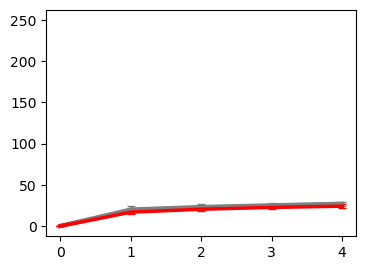

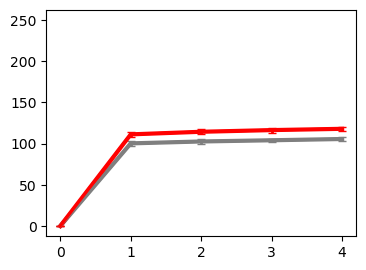

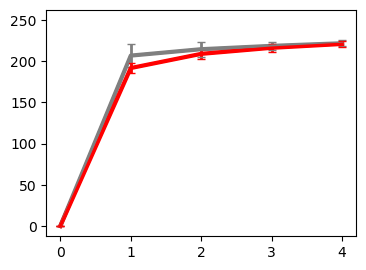

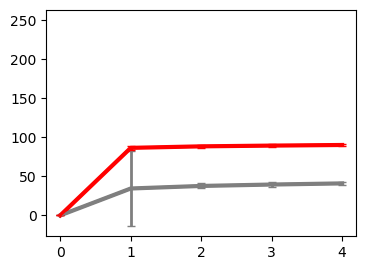

In [15]:
# Description of figure 4

ctrl_c = "#7f7f7f"
DRD_c = "red"
LW = 3.0

# Na-depleted, water intake
plt.figure(figsize=(4, 3), dpi=100)
plt.plot([0,1,2,3,4], sum_y_result[0][1]/N_exp, label="Saline", color=ctrl_c, linewidth = LW)
plt.errorbar([0,1,2,3,4], sum_y_result[0][1]/N_exp, yerr=error[0][1], color=ctrl_c, capsize=3, linewidth = LW-1)
plt.plot([0,1,2,3,4], sum_y_result[2][1]/N_exp, label="CNO", color=DRD_c, linewidth = LW)
plt.errorbar([0,1,2,3,4], sum_y_result[2][1]/N_exp, yerr=error[2][1], color=DRD_c, capsize=3, linewidth = LW-1)
plt.hlines(250, 0, 4, linestyle="dashed", color="w")
plt.xticks(np.arange(0, 4 + 1, 1))
#plt.legend()
plt.savefig('Salt_Exp4_Na_drd_water'+'.png')
plt.show()

# Na-depleted, saltwater intake
plt.figure(figsize=(4, 3), dpi=100)
plt.plot([0,1,2,3,4], sum_y_result[0][2]/N_exp, label="Saline", color=ctrl_c, linewidth = LW)
plt.errorbar([0,1,2,3,4], sum_y_result[0][2]/N_exp, yerr=error[0][2], color=ctrl_c, capsize=3, linewidth = LW-1)
plt.plot([0,1,2,3,4], sum_y_result[2][2]/N_exp, label="CNO", color=DRD_c, linewidth = LW)
plt.errorbar([0,1,2,3,4], sum_y_result[2][2]/N_exp, yerr=error[2][2], color=DRD_c, capsize=3, linewidth = LW-1)
plt.hlines(250, 0, 4, linestyle="dashed", color="w")
plt.xticks(np.arange(0, 4 + 1, 1))
#plt.legend()
plt.savefig('Salt_Exp4_Na_drd_salt'+'.png')
plt.show()

# Dehydrated, water intake
plt.figure(figsize=(4, 3), dpi=100)
plt.plot([0,1,2,3,4], sum_y_result[1][1]/N_exp, label="Saline", color=ctrl_c, linewidth = LW)
plt.errorbar([0,1,2,3,4], sum_y_result[1][1]/N_exp, yerr=error[1][1], color=ctrl_c, capsize=3, linewidth = LW-1)
plt.plot([0,1,2,3,4], sum_y_result[3][1]/N_exp, label="CNO", color=DRD_c, linewidth = LW)
plt.errorbar([0,1,2,3,4], sum_y_result[3][1]/N_exp, yerr=error[3][1], color=DRD_c, capsize=3, linewidth = LW-1)
plt.hlines(250, 0, 4, linestyle="dashed", color="w")
plt.xticks(np.arange(0, 4 + 1, 1))
#plt.legend()
plt.savefig('Salt_Exp4_W_drd_water'+'.png')
plt.show()

# Dehydrated, saktwater intake
plt.figure(figsize=(4, 3), dpi=100)
plt.plot([0,1,2,3,4], sum_y_result[1][2]/N_exp, label="Saline", color=ctrl_c, linewidth = LW)
plt.errorbar([0,1,2,3,4], sum_y_result[1][2]/N_exp, yerr=error[1][2], color=ctrl_c, capsize=3, linewidth = LW-1)
plt.plot([0,1,2,3,4], sum_y_result[3][2]/N_exp, label="CNO", color=DRD_c, linewidth = LW)
plt.errorbar([0,1,2,3,4], sum_y_result[3][2]/N_exp, yerr=error[3][2], color=DRD_c, capsize=3, linewidth = LW-1)
plt.hlines(250, 0, 4, linestyle="dashed", color="w")
plt.xticks(np.arange(0, 4 + 1, 1))
#plt.legend()
plt.savefig('Salt_Exp4_W_drd_salt'+'.png')
plt.show()

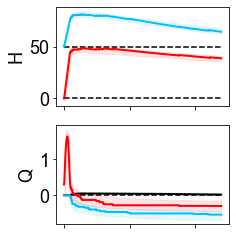

In [18]:
# Sodium depleted
plt.rcParams['font.family'] = 'Arial'
plt.rcParams["font.size"] = 18
fig = plt.figure(figsize=(4,4))
spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[1,1])

ax_l = []
ax_l.append(fig.add_subplot(spec[0]))
ax_l.append(fig.add_subplot(spec[1]))

CL = 0.95# Confidencial Level for Figures
Df = N_exp-1# degree of freedom for Figures

mean = [] #mean at t
STD = []
#SE = []# Standard Error for Figures
CI = np.zeros((5, N_i+1, 2)) #confidence interval at t

for j, h in zip(['H0','H1','Q0','Q1','Q2'], list(range(5))):
    for i in range(N_i+1):
        mean.append(sum(df.loc[df['trial']==i][j])/N_exp)
        STD.append(st.stdev(df.loc[df['trial']==i][j]))
        CI[h][i][0] = stats.t.interval(alpha = CL, df = Df, loc = mean[-1], scale = 2*STD[-1])[0]
        CI[h][i][1] = stats.t.interval(alpha = CL, df = Df, loc = mean[-1], scale = 2*STD[-1])[1]
        
length_l, length_s = N_i+1, N_i


ax_l[0].hlines(50, 0, N_i, linestyle="dashed")
ax_l[0].hlines(0, 0, N_i, linestyle="dashed")
ax_l[0].plot(df['H0'][:length_l], linewidth=2, color='#00BFFF')
ax_l[0].plot(df['H1'][:length_l], linewidth=2, color='red')
ax_l[0].fill_between(df.index[:length_l], CI[0, :, 0], CI[0, :, 1], color='#00BFFF', alpha=rd) #confidence interval curves.
ax_l[0].fill_between(df.index[:length_l], CI[1, :, 0], CI[1, :, 1], color='red', alpha=rd) #confidence interval curves.
ax_l[0].set_ylabel('H', fontsize=fs, fontname='Arial')
ax_l[0].tick_params(labelbottom=False)



ax_l[1].hlines(0, 0, N_i, linestyle="dashed")
ax_l[1].plot(df['Q0'][:length_l], linewidth=2, color='black')
ax_l[1].fill_between(df.index[:length_l], CI[2, :, 0], CI[2, :, 1], color='black', alpha=rd) #confidence interval curves.
ax_l[1].plot(df['Q1'][:length_l], linewidth=2, color='#00BFFF')
ax_l[1].fill_between(df.index[:length_l], CI[3, :, 0], CI[3, :, 1], color='#00BFFF', alpha=rd) #confidence interval curves.
ax_l[1].plot(df['Q2'][:length_l], linewidth=2, color='red')
ax_l[1].fill_between(df.index[:length_l], CI[4, :, 0], CI[4, :, 1], color='red', alpha=rd) #confidence interval curves.
ax_l[1].set_ylabel('Q' , fontsize=fs, fontname='Arial')
ax_l[1].tick_params(labelbottom=False)

fig.subplots_adjust(left=0.3)
plt.savefig('Salt_Exp4_Nadep_Q.png')



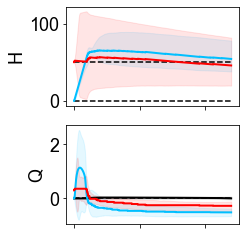

In [19]:
# Sodium depleted
plt.rcParams['font.family'] = 'Arial'
plt.rcParams["font.size"] = 18
w_fig = plt.figure(figsize=(4,4))
w_spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[1,1])

w_ax_l = []
w_ax_l.append(w_fig.add_subplot(w_spec[0]))
w_ax_l.append(w_fig.add_subplot(w_spec[1]))

CL = 0.95# Confidencial Level for Figures
Df = N_exp-1# degree of freedom for Figures

w_mean = [] #mean at t
w_STD = []
#SE = []# Standard Error for Figures
w_CI = np.zeros((5, N_i+1, 2)) #confidence interval at t

for j, h in zip(['H0','H1','Q0','Q1','Q2'], list(range(5))):
    for i in range(N_i+1):
        w_mean.append(sum(w_df.loc[w_df['trial']==i][j])/N_exp)
        w_STD.append(st.stdev(w_df.loc[w_df['trial']==i][j]))
        w_CI[h][i][0] = stats.t.interval(alpha = CL, df = Df, loc = w_mean[-1], scale = 2*w_STD[-1])[0]
        w_CI[h][i][1] = stats.t.interval(alpha = CL, df = Df, loc = w_mean[-1], scale = 2*w_STD[-1])[1]
        
length_l, length_s = N_i+1, N_i


w_ax_l[0].hlines(50, 0, N_i, linestyle="dashed")
w_ax_l[0].hlines(0, 0, N_i, linestyle="dashed")
w_ax_l[0].plot(w_df['H0'][:length_l], linewidth=2, color='#00BFFF')
w_ax_l[0].plot(w_df['H1'][:length_l], linewidth=2, color='red')
w_ax_l[0].fill_between(w_df.index[:length_l], w_CI[0, :, 0], w_CI[0, :, 1], color='#00BFFF', alpha=rd) #confidence interval curves.
w_ax_l[0].fill_between(w_df.index[:length_l], w_CI[1, :, 0], w_CI[1, :, 1], color='red', alpha=rd) #confidence interval curves.
w_ax_l[0].set_ylabel('H', fontsize=fs, fontname='Arial')
w_ax_l[0].tick_params(labelbottom=False)


w_ax_l[1].hlines(0, 0, N_i, linestyle="dashed")
w_ax_l[1].plot(w_df['Q0'][:length_l], linewidth=2, color='black')
w_ax_l[1].fill_between(w_df.index[:length_l], w_CI[2, :, 0], w_CI[2, :, 1], color='black', alpha=rd) #confidence interval curves.
w_ax_l[1].plot(w_df['Q1'][:length_l], linewidth=2, color='#00BFFF')
w_ax_l[1].fill_between(w_df.index[:length_l], w_CI[3, :, 0], w_CI[3, :, 1], color='#00BFFF', alpha=rd) #confidence interval curves.
w_ax_l[1].plot(w_df['Q2'][:length_l], linewidth=2, color='red')
w_ax_l[1].fill_between(w_df.index[:length_l], w_CI[4, :, 0], w_CI[4, :, 1], color='red', alpha=rd) #confidence interval curves.
w_ax_l[1].set_ylabel('Q' , fontsize=fs, fontname='Arial')
w_ax_l[1].tick_params(labelbottom=False)

w_fig.subplots_adjust(left=0.3)
plt.savefig('Salt_Exp4_wdep_Q.png')

